- plot shap_values for 
 - models #16 and #17
 - 5 samples and 50 samples
 - public and private data
- plot attr_all_22085_genes
 - models #16 and #17
 - use same samples as above
 - public and private data
- get_plot_per_cell_type() plots attributions coloured by cell type

In [1]:
%%capture output
!pip install shap
!pip install anndata
!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import shap

import anndata as ad
import scipy

In [3]:
os.chdir('../..')

In [4]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/open-problems-multimodal-3rd-solution/'
index_path = lrz_path + 'input/preprocess/cite/'

In [5]:
# all_22001_genes: 22001 features, handselected_gene_ids: 84 handselected genes
all_22001_genes = np.loadtxt('2.preprocess_to_feature/cite/all_22001_genes_names.txt', dtype=str)
handselected_gene_ids = np.loadtxt('2.preprocess_to_feature/cite/handselected_84_gene_ids.txt', dtype=str)

In [36]:
# function for plotting shap values
def shap_beeswarm(shap_values, X_test):
    shap.initjs()
    shap.summary_plot(shap_values[0], X_test.to_df(), feature_names=X_test.var_names)

def shap_bar_plot(shap_values, X_test):
    shap.initjs()
    shap.summary_plot(list(shap_values), plot_type = 'bar', feature_names = X_test.var_names)
    # 140 classes = each regression output

# shap_values = np.load('shap_values_16_50_samples.npy', allow_pickle=True).astype(float)
shap_values = np.load('4.model/pred/shap_values_16_restructured.npy', allow_pickle=True).astype(float)
# shap_values = np.load('4.model/pred/shap_values_16_50_samples_restructured.npy', allow_pickle=True).astype(float)

In [37]:
xtest = ad.read_h5ad('4.model/pred/X_test_shap_16_5_samples.h5ad')
xtest

AnnData object with n_obs × n_vars = 35 × 212
    obs: 'day', 'donor', 'cell_type', 'technology'

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


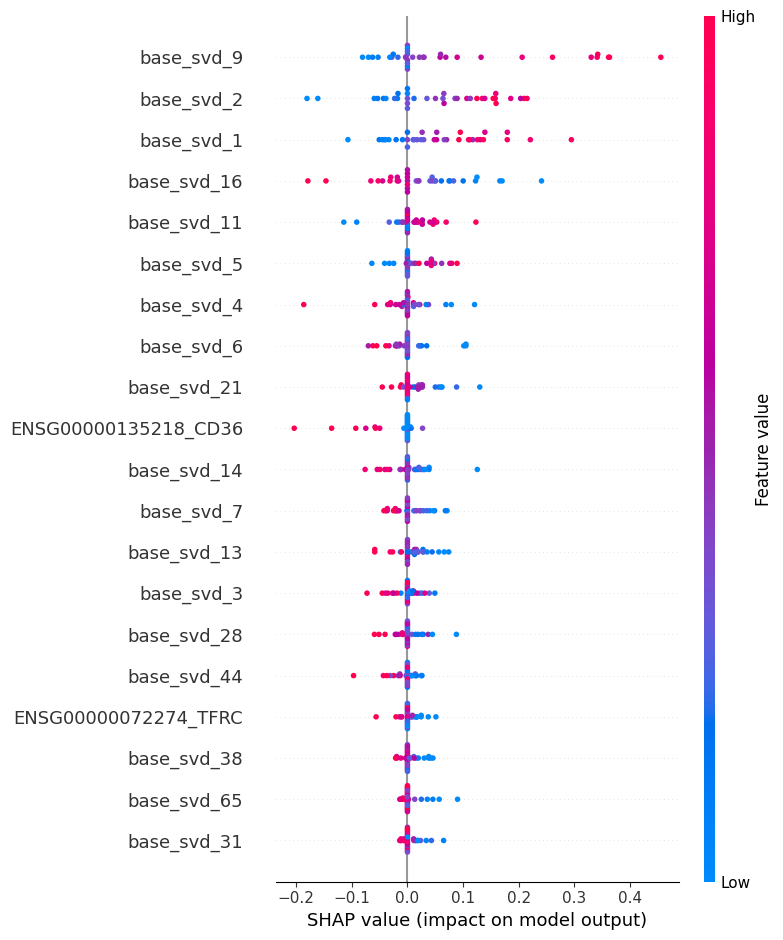

In [38]:
shap_beeswarm(shap_values, xtest)
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


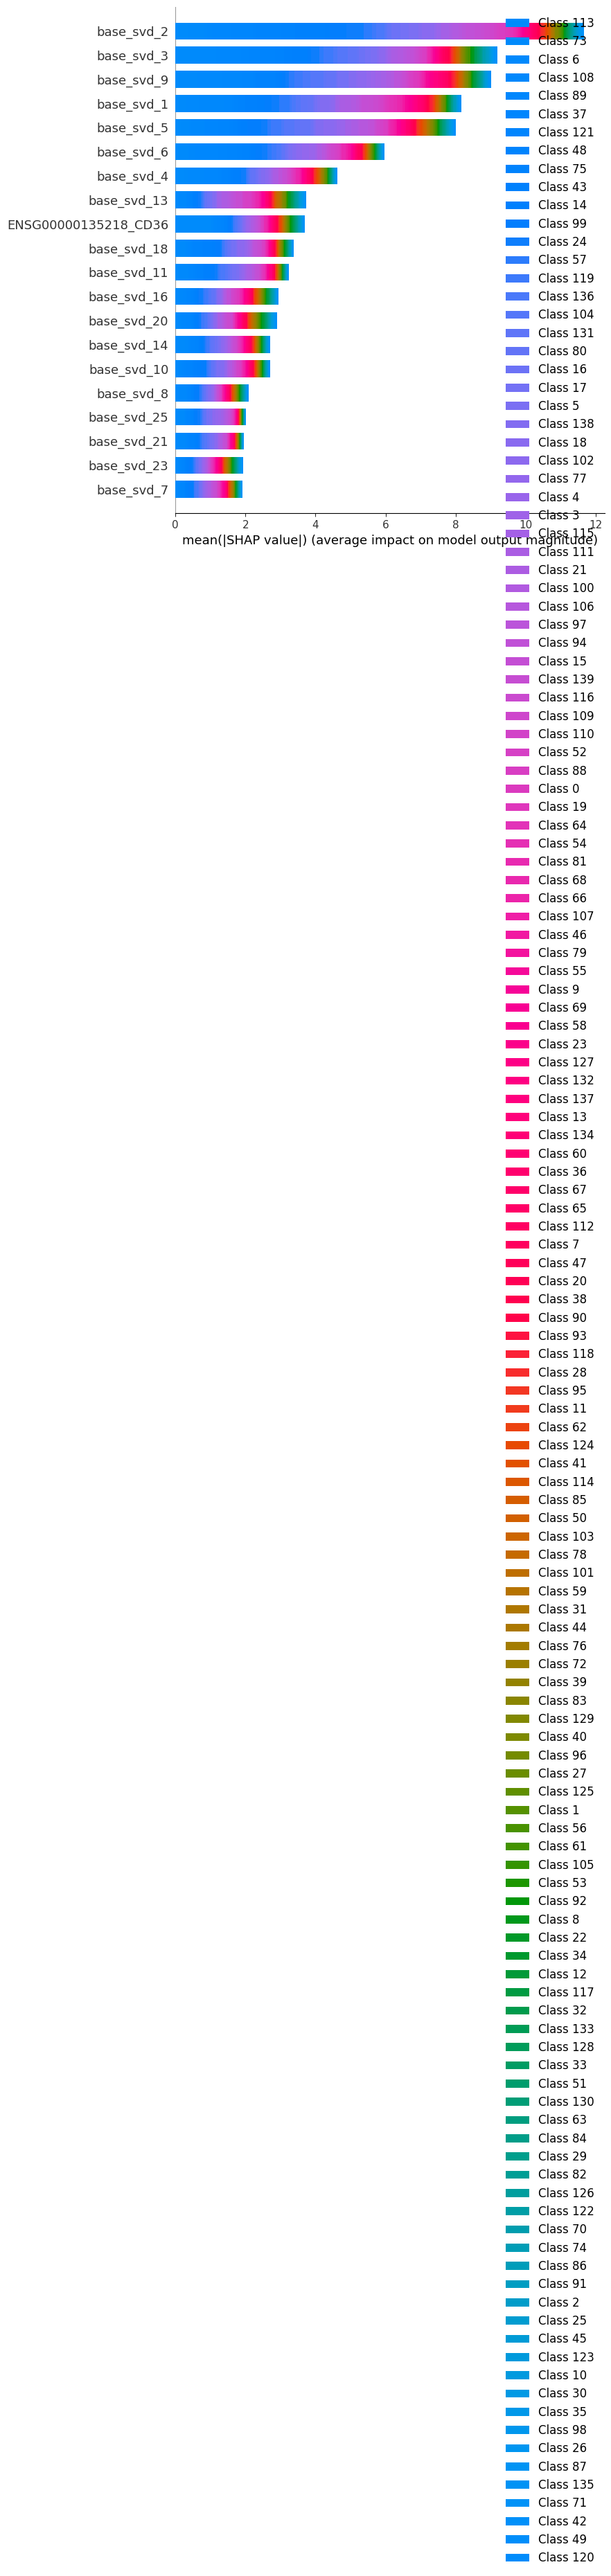

In [ ]:
shap_bar_plot(shap_values, xtest)

In [ ]:
shap_beeswarm()

### shap plot with backpropagated gene attributions

In [21]:
train_column = np.load(index_path + "train_cite_raw_inputs_idxcol.npz", allow_pickle=True)["columns"]
train_column

array(['ENSG00000121410_A1BG', 'ENSG00000268895_A1BG-AS1',
       'ENSG00000175899_A2M', ..., 'ENSG00000162378_ZYG11B',
       'ENSG00000159840_ZYX', 'ENSG00000074755_ZZEF1'], dtype=object)

In [29]:
test_inputs = scipy.sparse.load_npz(index_path + "test_cite_raw_inputs_values.sparse.npz")
# test_inputs = pd.DataFrame(test_inputs.toarray(), columns=list(all_22001_genes)+list(handselected_gene_ids))   # order?????? if directly from file probably totally ordered, not 22001+84
test_inputs = pd.DataFrame(test_inputs.toarray(), columns=train_column)   # should be correct order (totally ordered)

# get cell ids
test_ids = np.load(index_path + "test_cite_raw_inputs_idxcol.npz", allow_pickle=True)
test_index = test_ids["index"]
len(test_index)

test_inputs.index = test_index

test_inputs.head(2)

,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
83d6659a6a32,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,...,0.0,2.0,4.0,7.0,0.0,0.0,0.0,0.0,3.0,0.0
d98594f13d2e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,...,1.0,2.0,2.0,3.0,0.0,0.0,0.0,1.0,4.0,1.0


In [39]:
# cell ids used in xtest and SHAP:
sample_cells = xtest.obs_names
sample_cells

Index(['5cb9daaca7ac', '57b5bce6a192', '11e72851054b', 'dd7e07a59b0c',
       '02a718f16011', 'b1cb6121a2c7', '214bc6aff394', 'da246717db80',
       'a30e7f5314c8', 'c9830a8714fa', '578f22bfc5f3', '49df5e4cb86a',
       '5277e95c7757', 'dd561306b53a', 'ae054a1490d0', '040391b8f43a',
       'c9c58ca8473d', '333ebf338eb9', '8386b7aae280', '02eb272d91e0',
       '840f5b5b9e1c', '0cb16c2b5f57', '5654bae53c89', 'c6696c2373a9',
       '773c194014c4', '262376fe911c', '2c0f12a69cb6', '6a71f0524fb4',
       '6d8f45ff2e6c', 'ccf2a5f4134a', '6d54e7dd4353', 'b4f37f0e2605',
       '9dce83f9b3a7', 'b6b679747c17', 'fdf707a39a22'],
      dtype='object', name='cell_id')

In [40]:
# create xtest_all_genes: for shap plot, containing all 22085 genes instead of svd components
xtest_all_genes = test_inputs.loc[sample_cells]
print(xtest_all_genes.shape)
xtest_all_genes.head(2)

(35, 22085)


,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
5cb9daaca7ac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
57b5bce6a192,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,2.0,4.0,0.0,2.0,1.0,2.0,2.0,1.0


In [34]:
attr_all_22085_genes = pd.read_pickle('4.model/pred/attr_all_22085_genes_16_5_samples.pkl')
attr_all_22085_genes = attr_all_22085_genes.reindex(columns=train_column)
attr_all_22085_genes.head(2)

,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
0,-2.805793e-04,-0.000350,0.001712,-0.000411,-0.000060,-0.001241,0.001953,-0.006214,-0.000883,-0.000264,...,0.001543,-0.003873,-0.001430,-0.004269,0.000334,-0.000301,-0.000841,-0.000778,0.018235,0.000135
1,4.067557e-07,-0.000027,0.000132,-0.000048,0.000009,0.000188,-0.000248,0.001903,-0.000227,-0.000268,...,-0.000234,0.000547,0.000964,-0.001143,-0.000056,0.000014,-0.000261,0.001192,0.004383,-0.000027


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


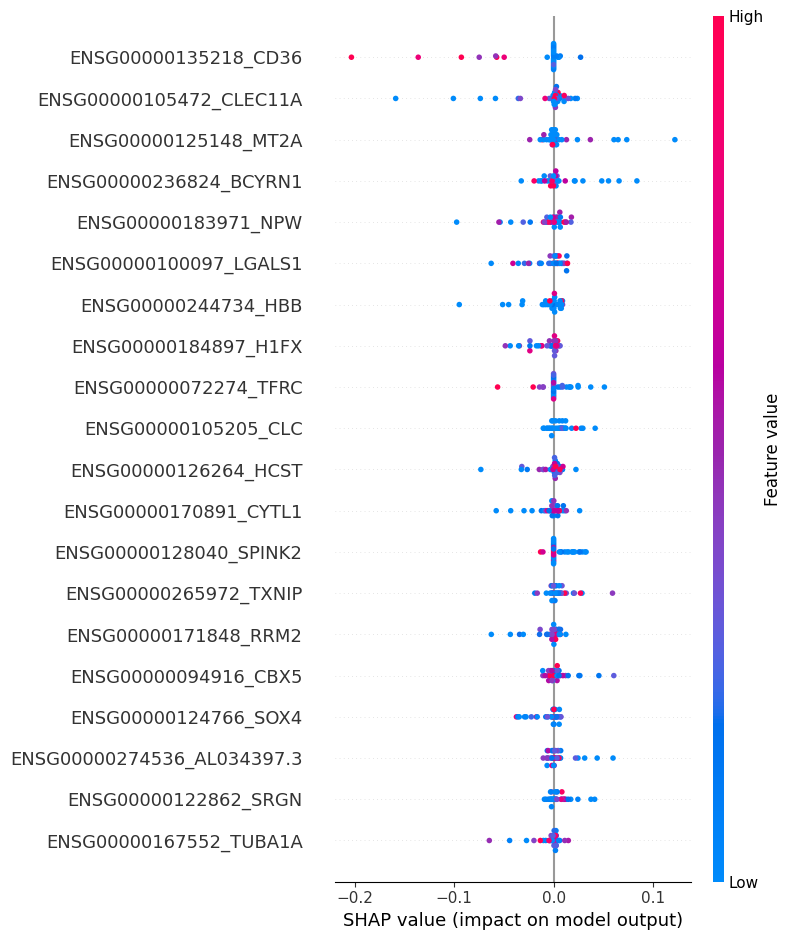

In [41]:
shap.initjs()
shap.summary_plot(np.array(attr_all_22085_genes), xtest_all_genes, feature_names=xtest_all_genes.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


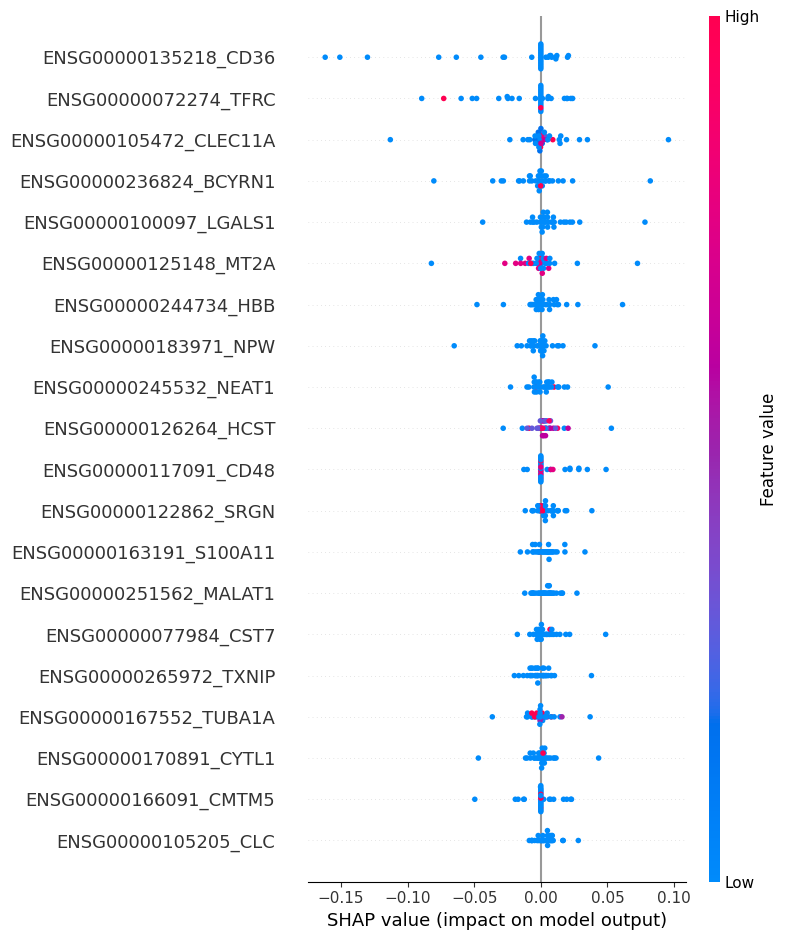

In [59]:
# DON'T EXECUTE
shap.initjs()
shap.summary_plot(np.array(attr_all_22085_genes), xtest_all_genes, feature_names=xtest_all_genes.columns)

### plot shap values per cell type similar to shap.summary_plot(shap_values[0], xtest)

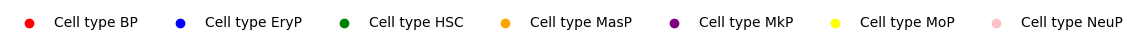

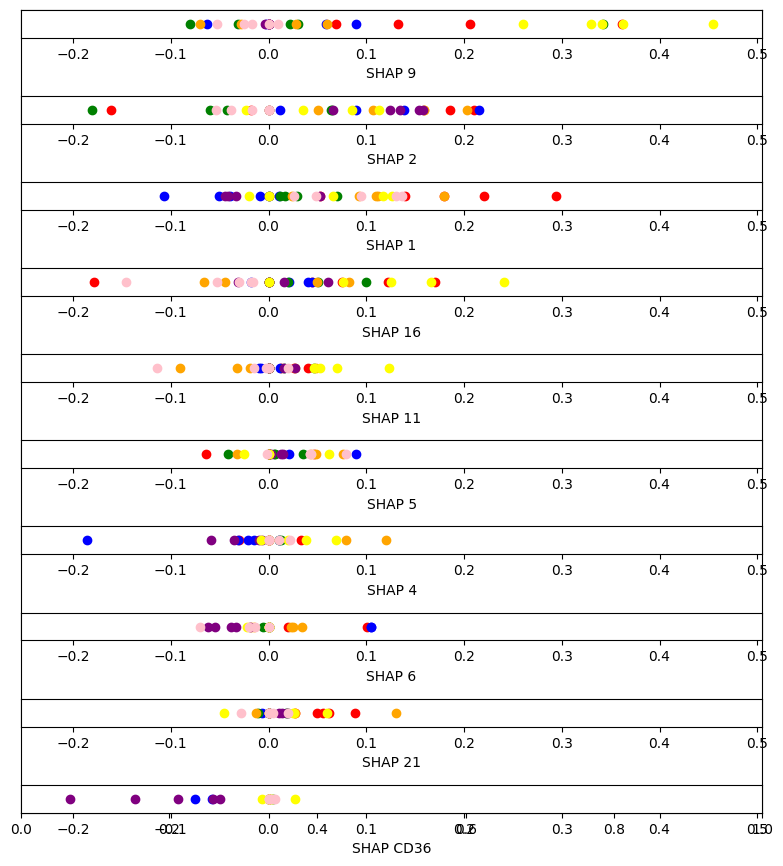

In [40]:
# function for plot: plot top 10 features colouring datapoints by cell type
def get_plot_per_cell_type(shap_values, xtest):

    # get top 10 features (see shap beeswarm plot)
    shap_sum = np.abs(shap_values[0]).sum(axis=0)
    top_features_indices = np.argsort(shap_sum)[::-1][:10]  # Get the indices of the top 10 features
    top_feature_names_shap = xtest.var_names[top_features_indices]
    
    # create df with shap values of top 10 features + cell type    
    shap_cell_types = {}
    for feature in top_feature_names_shap:
        column_name = 'SHAP ' + feature.split('_')[-1]
        column_values = shap_values[0, :, xtest.var_names.get_loc(feature)]
        shap_cell_types[column_name] = column_values

    # Add 'Cell Type' column
    shap_cell_types['Cell Type'] = xtest.obs['cell_type']

    # Create DataFrame
    shap_cell_types = pd.DataFrame(shap_cell_types)
    
    
    # code for actual plot:

    # Assign different colors to each class
    colors = {'BP': 'red', 'EryP': 'blue', 'HSC': 'green', 'MasP': 'orange', 'MkP': 'purple', 'MoP': 'yellow', 'NeuP': 'pink'}

    ## legend ##
    legend_fig, legend_ax = plt.subplots(figsize=(2, 2))

    for class_label, color in colors.items():
        legend_ax.scatter([], [], color=color, label=f'Cell type {class_label}')

    legend_ax.legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol=len(colors), frameon=False)
    legend_ax.axis('off')
    ## legend ##


    # plot shap values:
    fig, ax = plt.subplots(figsize=(8, 10))

    x_limit = (shap_values[0].min()-0.05, shap_values[0].max()+0.05)  # this is min and max for shap_values[0], TODO change once all 140 classes are considered

    # Remove y-axis ticks and labels
    ax.yaxis.set_visible(False)

    # Iterate over the columns in shap_cell_types to create subplots
    for i, column in enumerate(shap_cell_types.columns[:-1], start=1):

        ax = fig.add_subplot(len(shap_cell_types.columns)-1, 1, i)

        # Set the x-axis limits and label
        ax.set_xlim(x_limit)
        ax.set_xlabel(column)

        ax.yaxis.set_visible(False)

        # Plot the dots for the current column
        for index, row in shap_cell_types.iterrows():
            shap_value = row[column]
            class_label = row['Cell Type']
            color = colors[class_label]
            ax.plot(shap_value, 0, marker='o', color=color)

            
    fig.tight_layout(rect=[0, 0.1, 1, 1]) 
    legend_fig.subplots_adjust(top=0.1, bottom=0.05)

    plt.show()
    
    
get_plot_per_cell_type(shap_values, xtest)